In [1]:
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbn
from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertTokenizer, pipeline
import torch 
import os 
import re

from tkgdti.embed.AA2EMB import AA2EMB
from tkgdti.embed.SMILES2EMB import SMILES2EMB

import umap 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#https://huggingface.co/datasets/jglaser/binding_affinity?library=datasets
train = load_dataset("jglaser/binding_affinity",split='train[:90%]')
test = load_dataset("jglaser/binding_affinity",split='train[90%:]')


In [3]:
train_df = train.to_pandas()
test_df = test.to_pandas()
train_df.head()

,seq,smiles,affinity_uM,neg_log10_affinity_M,smiles_can,affinity
0,MTVPDRSEIAGKWYVVALASNTEFFLREKDKMKMAMARISFLGEDE...,CCCCCCCCCCCCCCCCCCCC(=O)O,0.026,7.585027,CCCCCCCCCCCCCCCCCCCC(=O)O,0.691712
1,APQTITELCSEYRNTQIYTINDKILSYTESMAGKREMVIITFKSGE...,OC[C@H]1O[C@H](Oc2cccc(c2)N(=O)=O)[C@@H]([C@H]...,500.000,3.301030,O=[N+]([O-])c1cccc(O[C@H]2O[C@H](CO)[C@H](O)[C...,-2.054668
2,VETFAFQAEIAQLMSLIINTFYSNKEIFLRELISNSSDALDKIRYE...,COc1ccc(cc1)c1c(onc1c1cc(C(C)C)c(cc1O)O)NC(=O)...,0.023,7.638272,COc1ccc(-c2c(-c3cc(C(C)C)c(O)cc3O)noc2NC(=O)C2...,0.725847
3,AAPFDKSKNVAQSIDQLIGQTPALYLNKLNNTKAKVVLKMECENPM...,OC[C@@H](C(=O)N[C@@H]([C@H](CC)C)C(=O)O)NC(=O)...,6.430,5.191789,CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC1...,-0.842542
4,YITFRSFTAVLIAFFLTLVLSPSFINRLRKIQRKKYTPTMGGIVIL...,CO[C@@H]1[C@H](O[C@H]([C@@H]1O)n1ccc(=O)[nH]c1...,0.185,6.732828,CO[C@@H]1[C@@H]([C@@H](O[C@H]2OC(C(=O)N[C@H]3C...,0.145386


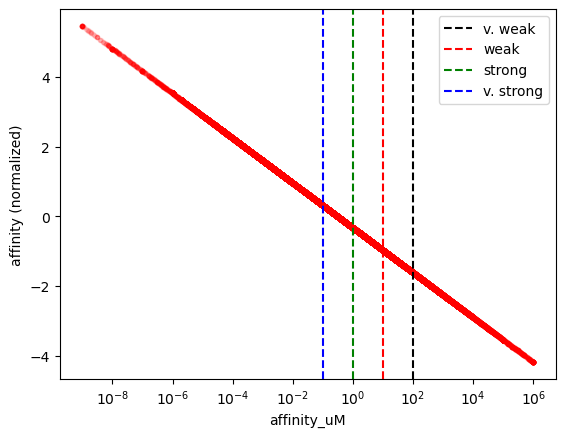

In [19]:
plt.figure()
plt.plot(train_df.affinity_uM, train_df.affinity, 'r.', alpha=0.1)
plt.xlabel('affinity_uM')
plt.ylabel('affinity (normalized)')
plt.xscale('log')
plt.axvline(100, color='k', linestyle='--', label='v. weak')
plt.axvline(10, color='r', linestyle='--', label='weak')
plt.axvline(1, color='g', linestyle='--', label='strong')
plt.axvline(0.1,  color='b', linestyle='--', label='v. strong')
plt.legend()
plt.show()

In [21]:
p_strong_dti = (train_df.affinity_uM.values < 1).mean()
p_strong_dti

0.6160626137287545

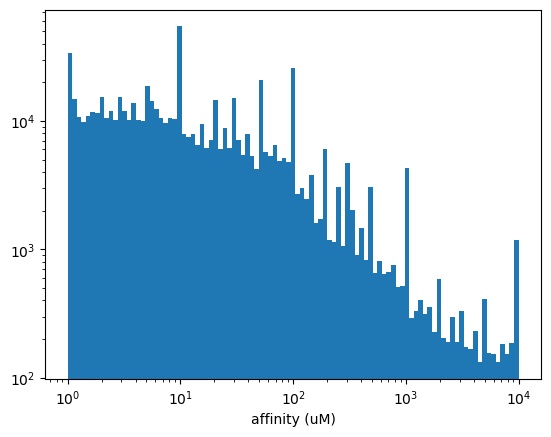

In [22]:
plt.figure() 
plt.hist(train_df.affinity_uM, bins=np.logspace(0, 4, 100))
plt.xlabel('affinity (uM)')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.figure()
plt.plot(-np.log(train_df.affinity_uM), train_df.affinity, 'r.', alpha=0.1)
plt.show()

In [ ]:
min(train_df.affinity_uM)

In [ ]:
plt.figure() 
plt.hist(train_df.affinity, bins=100)
plt.xlabel('neg log affinity normalized?')
plt.show()

In [ ]:
train_aas = train_df.seq.unique()
train_smiles = train_df.smiles_can.unique()

test_aas = test_df.seq.unique()
test_smiles = test_df.smiles_can.unique()

print(f"Number of unique sequences (train): {len(train_aas)}")
print(f"Number of unique smiles (train): {len(train_smiles)}")

print(f"Number of unique sequences (test): {len(test_aas)}")
print(f"Number of unique smiles (test): {len(test_smiles)}")

n_unique_test_aas = len(set(test_aas) - set(train_aas))
n_unique_test_smiles = len(set(test_smiles) - set(train_smiles))

print(f"Number of unique sequences (test) not in train: {n_unique_test_aas} / {len(test_aas)}")
print(f"Number of unique smiles (test) not in train: {n_unique_test_smiles} / {len(test_smiles)}")

In [ ]:
# Combine lists and find unique elements using sets
unique_smiles = set(train_smiles.tolist()).union(test_smiles.tolist())
unique_aas = set(train_aas.tolist()).union(test_aas.tolist())

# Convert sets back to lists if needed
smiles = list(unique_smiles)
aas = list(unique_aas)

print(f"Number of unique sequences: {len(aas)}")
print(f"Number of unique smiles: {len(smiles)}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

# Plot histogram for smiles lengths
axs[0].hist([len(s) for s in smiles], bins=50)
axs[0].set_title('SMILES Lengths')
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')

# Plot histogram for aas lengths
axs[1].hist([len(a) for a in aas], bins=50)
axs[1].set_title('Amino Acid Sequences Lengths')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
AA2E = AA2EMB()
z_prot = AA2E.embed(aas)

torch.save(z_prot, '../../extdata/jglaser/z_prot.pt')
with open('../../extdata/jglaser/amino_acids.txt', 'w') as f:
    f.write('\n'.join(aas))

In [ ]:
S2E = SMILES2EMB() 
z_drug = S2E.embed(smiles)

print()
print(z_drug.shape)

os.makedirs('../../extdata/jglaser', exist_ok=True)
torch.save(z_drug, '../../extdata/jglaser/z_drug.pt')
with open('../../extdata/jglaser/smiles.txt', 'w') as f:
    f.write('\n'.join(smiles))

In [ ]:
smiles = open('../../extdata/jglaser/smiles.txt').read().split('\n')
aas = open('../../extdata/jglaser/amino_acids.txt').read().split('\n')

In [ ]:
smiles2idx = {smile: i for i, smile in enumerate(smiles)}
aas2idx = {aa: i for i, aa in enumerate(aas)}

train_df = train_df.assign(partition='train')
test_df = test_df.assign(partition='test')
df = pd.concat([train_df, test_df])

df = df.assign(drug_idx=df.smiles_can.map(smiles2idx))
df = df.assign(prot_idx=df.seq.map(aas2idx))

df = df[['drug_idx', 'prot_idx', 'affinity', 'partition']]
df.to_csv('../../extdata/jglaser/jglaser_affinity_data.csv', index=False)

In [ ]:
df.head()